# Density estimation with Normalizing Flow

## Toy example

Use variables $\alpha$ and $\beta$ to define SR.

$$
p(\alpha) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\alpha^{2}}{2}}
$$

$$
p(\beta) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\beta^{2}}{2}}
$$

Use variable $y$ which has a weak dependence on $\alpha$ and $\beta$ for training and likelihood fitting.

$$
y = N( \mu = k\alpha + q\beta,\sigma = 1)
$$

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
import matplotlib.pyplot as plt

2023-02-06 21:34:55.890600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

In [47]:
%run plotting.py

<function matplotlib.pyplot.close(fig=None)>

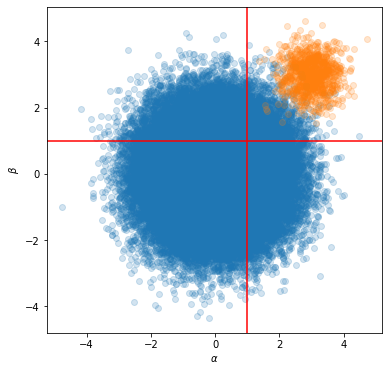

In [3]:
n1 = 100000
plt.figure(figsize=(6,6))
# Background
x1 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
x2 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.scatter(x1, x2, alpha = 0.2)
data = np.stack([x1, x2], axis = -1)
# Signal
n2 = 1000
x3 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
x4 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
plt.scatter(x3, x4, alpha = 0.2)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.show
plt.savefig('plots/full_bkg_sig.png')
plt.close

Blues shows the background events, and orange shows the signal events. The red lines define the CRs and SR. The upper right region is SR.

### Define the training model

In [4]:
def train(data):
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[16,16], activation='sigmoid')
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data.ndim]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data.ndim,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)
    model.compile(optimizer=tf.optimizers.Adam(),loss=lambda _, log_prob: -log_prob)
    batch_size = 512

    # Train
    model.fit(x=data,
              y=np.zeros((len(data),0), dtype=np.float32),
              batch_size=batch_size,
              epochs=20,
              shuffle=True,
              verbose=True)
    # Predict the full background distribution
    samples = distribution.sample(data.shape)
    return samples 

### Generate the 2D gaussian distribution.

In [5]:
samples_gen_full_bkg = train(data)

2023-02-06 21:35:02.607793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

Epoch 1/20
196/196 [==============================] - 1s 1ms/step - loss: 2.8599
Epoch 2/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8368
Epoch 3/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8366
Epoch 4/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8366
Epoch 5/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8367
Epoch 6/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8366
Epoch 7/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8366
Epoch 8/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8368
Epoch 9/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8367
Epoch 10/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8367
Epoch 11/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8369
Epoch 12/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8369
Epoch 13/20
196/196 [====

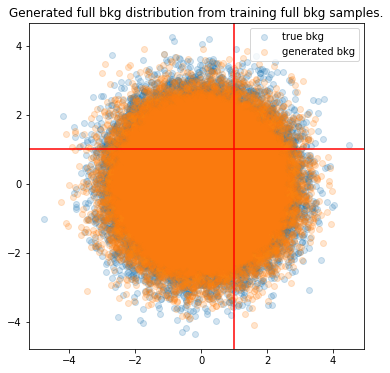

<Figure size 432x288 with 0 Axes>

In [6]:
plot_gen_full_bkg(samples_gen_full_bkg, x1, x2)

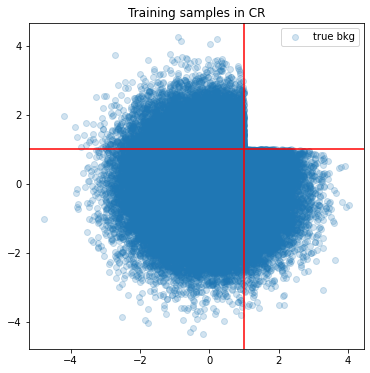

<function matplotlib.pyplot.close(fig=None)>

<Figure size 432x288 with 0 Axes>

In [7]:
# Train on background distribution in CR
CR_mask = np.logical_not((data[:,0] > 1) & (data[:,1] > 1))

# Plot partial background that's been trained on
x1_CR = data[CR_mask][:,0]
x2_CR = data[CR_mask][:,1]
plt.figure(figsize=(6,6))
plt.scatter(x1_CR, x2_CR, alpha = 0.2, label = 'true bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.title("Training samples in CR")
plt.legend()
plt.show()
plt.savefig('plots/train_CR_bkg.png')
plt.close

In [8]:
samples_gen_SRfromCR_bkg = train(data[CR_mask])

Epoch 1/20
191/191 [==============================] - 1s 1ms/step - loss: 2.8036
Epoch 2/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7899
Epoch 3/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7893
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7890
Epoch 5/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7891
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7888
Epoch 7/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7888
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7888
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7885
Epoch 10/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7884
Epoch 11/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7884
Epoch 12/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7885
Epoch 13/20
191/191 [====

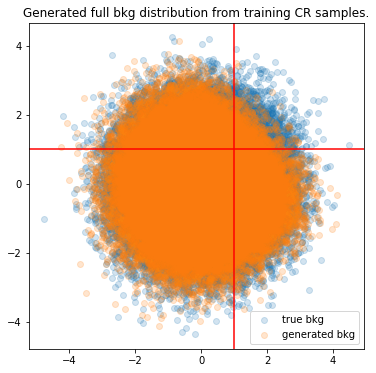

<Figure size 432x288 with 0 Axes>

In [9]:
plot_gen_SRfromCR_bkg(samples_gen_SRfromCR_bkg, x1, x2)

### Define a condiftioned training model

In [65]:
def train_conditioned(data, cond, batch_size=512, epochs = 20, learning_rate=1e-3):
    mask_train = np.logical_not((cond[:,0] > 1) & (cond[:,1] > 1))
    mask_gen = (cond[:,0] > 1) & (cond[:,1] > 1)
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(
        params=2, 
        hidden_units=[16,16], 
        event_shape=(data.ndim,),
        conditional=True,
        activation='sigmoid',
        conditional_event_shape=(cond.ndim,)
    )
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data.ndim]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data.ndim,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(cond.ndim,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(
        x_, bijector_kwargs={'conditional_input': c_})
    model = tfk.Model([x_, c_], log_prob_)
    
    # Train
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss=lambda _, log_prob: -log_prob)
    model.fit(x=[data[mask_train], cond[mask_train]],
              y=np.zeros((len(data[mask_train]),0), dtype=np.float32),
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True,
              verbose=True)
    # Predict the full background distribution
    samples = distribution.sample(
        data[mask_gen].shape[0],
        bijector_kwargs={'conditional_input': cond[mask_gen]}
    )
    return samples 

### Generate $ y = N( \mu = k\alpha + q\beta,\sigma = 1)$

In [11]:
def Y(k, q, x1, x2):
    return np.random.normal(k*x1 + q*x2, 1, n1).astype(dtype=np.float32)

**y = random**

<function matplotlib.pyplot.close(fig=None)>

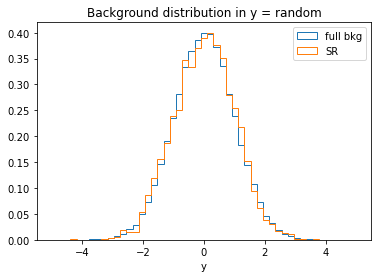

In [12]:
Y_rand = Y(0, 0, x1, x2)
mask_SR = (x1 > 1) & (x2 > 1)
plt.figure(figsize=(6,4))
bins = np.linspace(-5, 5, 50)
plt.hist(Y_rand, bins = bins, density = True, histtype='step', label='full bkg')
plt.hist(Y_rand[mask_SR], bins = bins, density = True, histtype='step', label='SR')
plt.title("Background distribution in y = random")
plt.xlabel("y")
plt.legend()
plt.show
plt.savefig('plots/full_bkg_in_y_random.png')
plt.close

In [68]:
samples_gen_SR_bkg_in_y_random = train_conditioned(Y_rand,data,epochs=50)

Epoch 1/50
191/191 [==============================] - 2s 2ms/step - loss: 8.1687
Epoch 2/50
191/191 [==============================] - 0s 2ms/step - loss: 3.0310
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 2.6811
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 2.5632
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 2.4828
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 2.4041
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 2.3187
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 2.2237
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 2.1180
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 2.0019
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 1.8776
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss: 1.7540
Epoch 13/50
191/191 [====

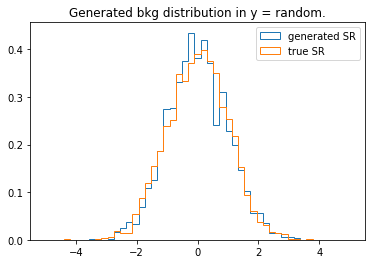

In [69]:
plot_gen_SR_bkg_in_y_random(samples_gen_SR_bkg_in_y_random, Y_rand[mask_SR])

**Increase dependence of $\alpha$ and $\beta$**

<function matplotlib.pyplot.close(fig=None)>

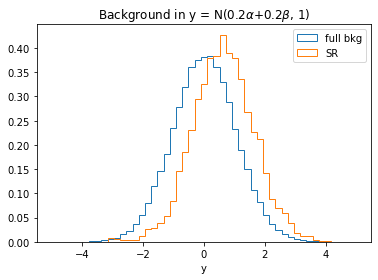

In [70]:
Y_cond2 = Y(0.2, 0.2, x1, x2)
plt.figure(figsize=(6,4))
bins = np.linspace(-5, 5, 50)
plt.hist(Y_cond2, bins = bins, density = True, histtype='step', label='full bkg')
plt.hist(Y_cond2[mask_SR], bins = bins, density = True, histtype='step', label='SR')
plt.title("Background in y = N($0.2\\alpha$+0.2$\\beta$, 1)")
plt.xlabel("y")
plt.legend()
plt.show
plt.savefig('plots/full_bkg_in_y_cond2.png')
plt.close

In [71]:
samples_cond2 = train_conditioned(Y_cond2,data,epochs=50)

Epoch 1/50
191/191 [==============================] - 1s 1ms/step - loss: 1.8392
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4552
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4273
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4255
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4243
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4234
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4225
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4220
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4214
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4210
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4205
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4203
Epoch 13/50
191/191 [====

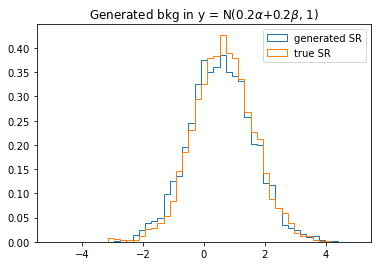

In [72]:
plot_gen_SR_bkg_in_y_cond(samples_cond2, Y_cond2[mask_SR], 0.2, 0.2)

<function matplotlib.pyplot.close(fig=None)>

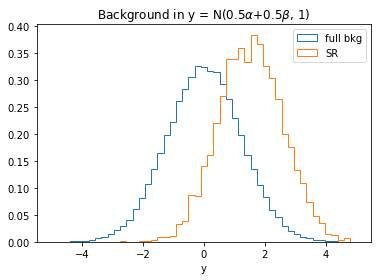

In [73]:
Y_cond5 = Y(0.5, 0.5, x1, x2)
plt.figure(figsize=(6,4))
bins = np.linspace(-5, 5, 50)
plt.hist(Y_cond5, bins = bins, density = True, histtype='step', label='full bkg')
plt.hist(Y_cond5[mask_SR], bins = bins, density = True, histtype='step', label='SR')
plt.title("Background in y = N($0.5\\alpha$+0.5$\\beta$, 1)")
plt.xlabel("y")
plt.legend()
plt.show
plt.savefig('plots/full_bkg_in_y_cond5.png')
plt.close

In [74]:
samples_cond5 = train_conditioned(Y_cond5,data)

Epoch 1/20
191/191 [==============================] - 1s 1ms/step - loss: 2.0448
Epoch 2/20
191/191 [==============================] - 0s 1ms/step - loss: 1.5996
Epoch 3/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4625
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4304
Epoch 5/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4248
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4237
Epoch 7/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4234
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4231
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4227
Epoch 10/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4224
Epoch 11/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4220
Epoch 12/20
191/191 [==============================] - 0s 1ms/step - loss: 1.4218
Epoch 13/20
191/191 [====

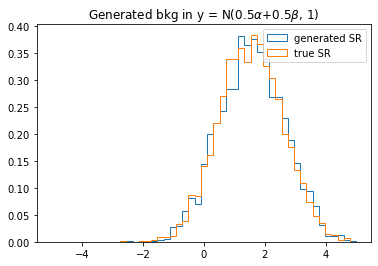

In [75]:
plot_gen_SR_bkg_in_y_cond(samples_cond5, Y_cond5[mask_SR], 0.5, 0.5)

In [76]:
Y_cond8 = Y(0.8, 0.8, x1, x2)
samples_cond8 = train_conditioned(Y_cond8,data,epochs=50)

Epoch 1/50
191/191 [==============================] - 1s 1ms/step - loss: 5.2648
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 2.1911
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 2.0687
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 2.0014
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 1.9246
Epoch 6/50
191/191 [==============================] - 0s 1ms/step - loss: 1.8288
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 1.7098
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 1.5785
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4783
Epoch 10/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4395
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4317
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss: 1.4298
Epoch 13/50
191/191 [====

### Compare different $\alpha$ and $\beta$ dependence

<function matplotlib.pyplot.close(fig=None)>

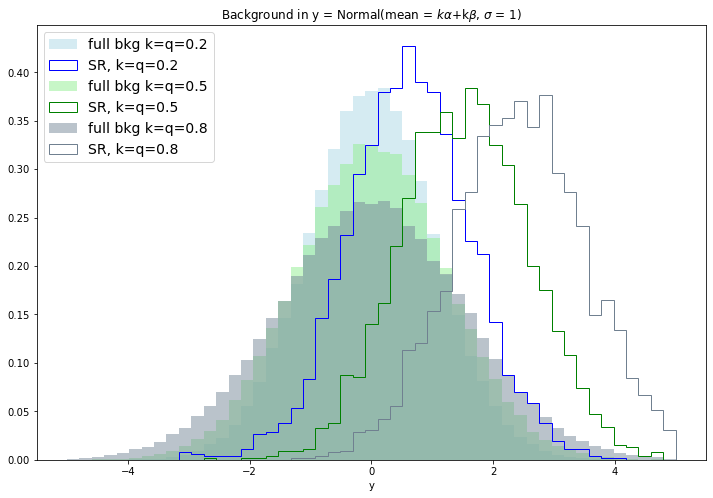

In [77]:
plt.figure(figsize=(12,8))
bins = np.linspace(-5, 5, 50)
plt.hist(Y_cond2, bins = bins, density = True, histtype='stepfilled', alpha = 0.5, color = 'lightblue', label='full bkg k=q=0.2')
plt.hist(Y_cond2[mask_SR], bins = bins, density = True, histtype='step', color = 'blue', label='SR, k=q=0.2')
plt.hist(Y_cond5, bins = bins, density = True, histtype='stepfilled', alpha = 0.5, color = 'lightgreen', label='full bkg k=q=0.5')
plt.hist(Y_cond5[mask_SR], bins = bins, density = True, histtype='step', color = 'green', label='SR, k=q=0.5')
plt.hist(Y_cond8, bins = bins, density = True, histtype='stepfilled', alpha = 0.5, color = 'lightslategrey', label='full bkg k=q=0.8')
plt.hist(Y_cond8[mask_SR], bins = bins, density = True, histtype='step', color = 'slategrey', label='SR, k=q=0.8')
plt.title("Background in y = Normal(mean = $k\\alpha$+k$\\beta$, $\sigma$ = 1)")
plt.xlabel("y")
plt.legend(loc='upper left', fontsize = 14)
plt.show
plt.savefig('plots/full_bkg_in_y_cond.png')
plt.close

In [88]:
%run plotting.py

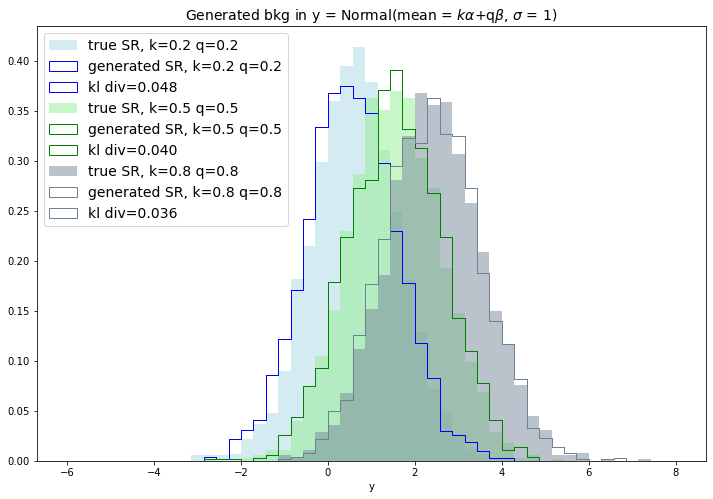

In [89]:
plot_gen_SR_bkg_in_y_cond_list([samples_cond2, samples_cond5, samples_cond8], [Y_cond2[mask_SR], Y_cond5[mask_SR], Y_cond8[mask_SR]], [0.2, 0.5, 0.8], [0.2, 0.5, 0.8])